<center><a target="_blank"
<hr />

# <h1 align="center"> Predicting E-Commerce Product Recommendations from Reviews  </h1>

<hr />




![](https://github.com/dipanjanS/feature_engineering_session_dhs18/blob/master/ecommerce_product_ratings_prediction/clothing_banner.jpg?raw=1)

This is a classic NLP problem dealing with data from an e-commerce store focusing on women's clothing. Each record in the dataset is a customer review which consists of the review title, text description and a recommendation 0 or 1) for a product amongst other features


__Main Objective:__ Leverage the review text attributes and build deep learning models to predict the recommendation (classification)

# Load up basic dependencies

In [ ]:
!pip install --upgrade tensorflow_hub

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00


# Load and View the Dataset

The data is available at https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews from where you can download it.

In [ ]:
df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Basic Data Processing

- Merge all review text attributes (title, text description) into one attribute
- Subset out columns of interest

In [ ]:
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df.head()

,Review,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws I had such high hopes ...,0
3,"My favorite buy! I love, love, love this jumps...",1
4,Flattering shirt This shirt is very flattering...,1


## Remove all records with no review text

In [ ]:
df = df[df['Review'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22642 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       22642 non-null  object
 1   Recommended  22642 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.7+ KB


## There is some imbalance in the data based on product recommendations

In [ ]:
df['Recommended'].value_counts()

,count
Recommended,
1,18541
0,4101


# Build train and test datasets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((15849, 1), (6793, 1))

In [ ]:
from collections import Counter
Counter(y_train), Counter(y_test)

(Counter({1: 12966, 0: 2883}), Counter({1: 5575, 0: 1218}))

In [ ]:
X_train.head(3)

,Review
4654,Sexy and flows I love this jumpsuit! i'm usual...
5333,Wanted to love it The dresss is much shorter t...
22502,So cute! though inside not soft I got the crea...


In [ ]:
y_train.value_counts()

,count
Recommended,
1,12966
0,2883


# Text Pre-processing and Wrangling

We do minimal text pre-processing here given we will be building deep learning models.

In [ ]:
import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs


In [ ]:
X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

100%|██████████| 6793/6793 [00:02<00:00, 3379.49it/s]


# Experiment 1: Train Classfier with CNN + FastText Embeddings & Evaluate Performance on Test Data

__Note:__ Skip FastText Embeddings part if it takes too much time to download or load it since it does consume a good amount of memory to load the pretrained embeddings.

Here is the link to get embeddings from facebook's pre-trained fasttext model.

https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [ ]:
train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']

In [ ]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_clean_text)
t.word_index['<PAD>'] = 0

In [ ]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]),
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]),
      t.word_index['<UNK>'])

('vaca', 12081) ('<PAD>', 0) 1


In [ ]:
train_sequences = t.texts_to_sequences(train_clean_text)
test_sequences = t.texts_to_sequences(test_clean_text)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=12082
Number of Documents=15849


In [ ]:
max(len(i) for i in train_sequences)

121

In [ ]:
max(len(doc.split()) for doc in train_clean_text)

121

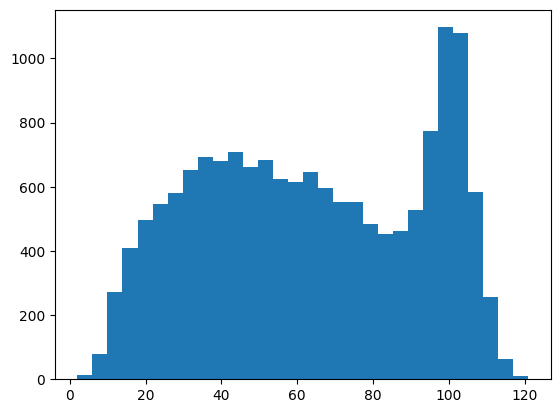

In [ ]:
plt.hist([len(item) for item in train_sequences], bins=30);

In [ ]:
MAX_SEQUENCE_LENGTH = 121

# pad dataset to a maximum review length in words
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_seqs.shape, test_seqs.shape

((15849, 121), (6793, 121))

In [ ]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=32

In [ ]:
import os

# Check if the file and its unzipped content already exist
file_name_zip = "wiki-news-300d-1M.vec.zip"
file_name_vec = "wiki-news-300d-1M.vec"

# If the zip file doesn't exist, download it
if not os.path.exists(file_name_zip):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip




--2026-02-09 01:32:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.84, 13.35.37.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   117MB/s    in 3.9s    

2026-02-09 01:32:30 (166 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
# If the unzipped .vec file doesn't exist, unzip the zip file
if not os.path.exists(file_name_vec):
    !unzip -o wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx,
                                           max_features=VOCAB_SIZE,
                                           embedding_size=EMBED_SIZE,
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(12082, 300)

In [ ]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    trainable=True))

model.layers[0].set_weights([ft_embeddings])

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 121, 300)       │     3,624,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 121, 256)       │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,408,153 (16.82 MB)

 Trainable params: 4,408,153 (16.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input

# Define the model
model = Sequential([
    Input(shape=(121, 1)),  # Explicit input shape definition
    Conv1D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 119, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 59, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 944)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         9,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,525 (37.21 KB)

 Trainable params: 9,525 (37.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_seqs, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[es],
          verbose=2)

Epoch 1/100
446/446 - 6s - 13ms/step - accuracy: 0.8109 - loss: 1.7453 - val_accuracy: 0.8013 - val_loss: 0.6455
Epoch 2/100
446/446 - 1s - 3ms/step - accuracy: 0.8202 - loss: 0.5257 - val_accuracy: 0.8013 - val_loss: 0.6911
Epoch 3/100
446/446 - 1s - 3ms/step - accuracy: 0.8202 - loss: 0.5045 - val_accuracy: 0.8013 - val_loss: 0.5241
Epoch 4/100
446/446 - 1s - 3ms/step - accuracy: 0.8203 - loss: 0.4920 - val_accuracy: 0.8013 - val_loss: 0.5676
Epoch 5/100
446/446 - 2s - 4ms/step - accuracy: 0.8203 - loss: 0.4783 - val_accuracy: 0.8013 - val_loss: 0.5031
Epoch 6/100
446/446 - 1s - 3ms/step - accuracy: 0.8203 - loss: 0.4724 - val_accuracy: 0.8013 - val_loss: 0.5110
Epoch 7/100
446/446 - 1s - 3ms/step - accuracy: 0.8203 - loss: 0.4710 - val_accuracy: 0.8013 - val_loss: 0.4964
Epoch 8/100
446/446 - 1s - 3ms/step - accuracy: 0.8203 - loss: 0.4701 - val_accuracy: 0.8013 - val_loss: 0.4973
Epoch 9/100
446/446 - 1s - 3ms/step - accuracy: 0.8203 - loss: 0.4700 - val_accuracy: 0.8013 - val_loss

In [ ]:
predictions = (model.predict(test_seqs) > 0.5).astype("int32")

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1218
           1       0.82      1.00      0.90      5575

    accuracy                           0.82      6793
   macro avg       0.41      0.50      0.45      6793
weighted avg       0.67      0.82      0.74      6793



,0,1
0,0,1218
1,4,5571


# Experiment 2: Train Classfier with LSTM + FastText Embeddings & Evaluate Performance on Test Data

__Note:__ Skip FastText Embeddings part if it takes too much time to download or load it since it does consume a good amount of memory to load the pretrained embeddings.

In [ ]:
LSTM_DIM = 256

# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    trainable=True))

model.layers[0].set_weights([ft_embeddings])

#model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 121, 300)       │     3,624,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,326,809 (16.51 MB)

 Trainable params: 4,326,809 (16.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_seqs, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8464 - loss: 0.3850 - val_accuracy: 0.8852 - val_loss: 0.2818
Epoch 2/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8917 - loss: 0.2587 - val_accuracy: 0.8763 - val_loss: 0.2872
Epoch 3/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9293 - loss: 0.1815 - val_accuracy: 0.9054 - val_loss: 0.2646
Epoch 4/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9523 - loss: 0.1190 - val_accuracy: 0.9035 - val_loss: 0.3251
Epoch 5/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9722 - loss: 0.0780 - val_accuracy: 0.9003 - val_loss: 0.3586
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
predictions = (model.predict(test_seqs) > 0.5).astype("int32")

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1218
           1       0.94      0.94      0.94      5575

    accuracy                           0.91      6793
   macro avg       0.84      0.84      0.84      6793
weighted avg       0.91      0.91      0.91      6793



,0,1
0,909,309
1,319,5256


# Experiment 3: Train Classfier with NNLM Universal Embedding Model




In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from tf_keras import Sequential
from tf_keras.layers import Dense, Dropout
from tf_keras.losses import BinaryCrossentropy
from tf_keras.metrics import BinaryAccuracy
from tf_keras.callbacks import EarlyStopping

MODEL_REF = "https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1"
hub_layer = hub.KerasLayer(MODEL_REF, input_shape=[], dtype=tf.string, trainable=False)

In [ ]:
model = Sequential()
model.add(hub_layer)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[BinaryAccuracy(threshold=0.0, name='accuracy')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 256)               13056     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 48269705 (184.13 MB)
Trainable params: 791

In [ ]:
# Fit the model
es = EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_clean_text, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/tf_keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


446/446 [==============================] - 6s 6ms/step - loss: 0.3635 - accuracy: 0.8200 - val_loss: 0.3415 - val_accuracy: 0.8006
Epoch 2/100
446/446 [==============================] - 2s 5ms/step - loss: 0.3285 - accuracy: 0.8200 - val_loss: 0.3295 - val_accuracy: 0.8006
Epoch 3/100
446/446 [==============================] - 2s 5ms/step - loss: 0.3229 - accuracy: 0.8200 - val_loss: 0.3263 - val_accuracy: 0.8006
Epoch 4/100
446/446 [==============================] - 2s 5ms/step - loss: 0.3165 - accuracy: 0.8200 - val_loss: 0.3268 - val_accuracy: 0.8006
Epoch 5/100
446/446 [==============================] - 3s 6ms/step - loss: 0.3133 - accuracy: 0.8200 - val_loss: 0.3274 - val_accuracy: 0.8006
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
predictions = (model.predict(test_clean_text) > 0.5).astype("int32")

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

213/213 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.63      0.43      0.51      1218
           1       0.88      0.94      0.91      5575

    accuracy                           0.85      6793
   macro avg       0.75      0.69      0.71      6793
weighted avg       0.84      0.85      0.84      6793



,0,1
0,529,689
1,317,5258


# Experiment 4: Train Classfier with BERT

##### Note: You might need to restart the notebook environment on colab after installing the below library


##### Note: Run the below cell to get all the pre-processed data again in case you needed to reload the notebook after the above installation

In [ ]:
!pip -q install "transformers==4.41.2" "tf-keras" "tensorflow==2.19.0"

In [ ]:
import os

os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('https://github.com/dipanjanS/text-analytics-with-python/raw/master/media/Womens%20Clothing%20E-Commerce%20Reviews%20-%20NLP.csv', keep_default_na=False)
df['Review'] = (df['Title'].map(str) +' '+ df['Review Text']).apply(lambda row: row.strip())
df['Recommended'] = df['Recommended IND']
df = df[['Review', 'Recommended']]
df = df[df['Review'] != '']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Recommended']), df['Recommended'], test_size=0.3, random_state=42)

import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

X_train['Clean Review'] = normalize_corpus(X_train['Review'].values)
X_test['Clean Review'] = normalize_corpus(X_test['Review'].values)

train_clean_text = X_train['Clean Review']
test_clean_text = X_test['Clean Review']


100%|██████████| 6793/6793 [00:01<00:00, 5016.01it/s]


#### Train and Evaluate your BERT model using `transformers`

In [ ]:
import transformers

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        segments = [0] * max_seq_length
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)

    encoded = np.array([all_ids, all_masks, all_segments])

    return encoded

In [ ]:
MAX_SEQ_LENGTH = 121

In [ ]:
import tensorflow as tf

In [ ]:
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="inp_id")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="inp_mask")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="inp_segment")

def bert_layer(inputs):
    return bert_model(input_ids=inputs[0], attention_mask=inputs[1], token_type_ids=inputs[2])

bert_outputs = tf.keras.layers.Lambda(bert_layer, output_shape=(MAX_SEQ_LENGTH, 768))([inp_id, inp_mask, inp_segment])

pooled_output = bert_outputs[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=[inp_id, inp_mask, inp_segment], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inp_id (InputLayer)         [(None, 121)]                0         []                            
                                                                                                  
 inp_mask (InputLayer)       [(None, 121)]                0         []                            
                                                                                                  
 inp_segment (InputLayer)    [(None, 121)]                0         []                            
                                                                                                  
 lambda (Lambda)             TFBaseModelOutputWithPooli   0         ['inp_id[0][0]',              
                             ngAndCrossAttentions(last_              'inp_mask[0][0]',        

In [ ]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               train_clean_text,
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 15849/15849 [00:14<00:00, 1096.02it/s]


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
try:
    model.fit([train_features_ids,
               train_features_masks,
               train_features_segments], y_train,
              validation_split=0.1,
              epochs=3,
              batch_size=25,  # Reduced batch size
              callbacks=[es],
              shuffle=True,
              verbose=1)
except tf.errors.ResourceExhaustedError:
    print("OOM: Reducing the batch size further")
    model.fit([train_features_ids,
               train_features_masks,
               train_features_segments], y_train,
              validation_split=0.1,
              epochs=3,
              batch_size=8,  # Further reduced batch size
              callbacks=[es],
              shuffle=True,
              verbose=1)


Epoch 1/3
571/571 [==============================] - 163s 257ms/step - loss: 0.4679 - accuracy: 0.8186 - val_loss: 0.4768 - val_accuracy: 0.8006
Epoch 2/3
571/571 [==============================] - 143s 250ms/step - loss: 0.4425 - accuracy: 0.8203 - val_loss: 0.4657 - val_accuracy: 0.8006
Epoch 3/3
571/571 [==============================] - 142s 249ms/step - loss: 0.4253 - accuracy: 0.8212 - val_loss: 0.4312 - val_accuracy: 0.8013
Restoring model weights from the end of the best epoch: 3.


In [ ]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                            test_clean_text,
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 6793/6793 [00:05<00:00, 1220.70it/s]


Test Features: (6793, 121) (6793, 121) (6793, 121)


In [ ]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,
                                            test_features_segments], verbose=0).ravel()]

print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.01      0.01      1218
           1       0.82      1.00      0.90      5575

    accuracy                           0.82      6793
   macro avg       0.85      0.50      0.46      6793
weighted avg       0.83      0.82      0.74      6793



,0,1
0,7,1211
1,1,5574
